In [1]:
import pdal
import json
import numpy as np

In [2]:
import geopandas as gpd
import pandas as pd

In [3]:
areas = gpd.read_file("./gis/area-de-analise-BN8AU-2.geojson")

In [4]:
areas['area'] = areas.area

In [5]:
areas

,Name,description,timestamp,begin,end,geometry,area
0,Terreno - Projeto,None,None,None,None,"POLYGON Z ((333264.881 7391451.155 0.000, 3333...",1.981811e+04
1,Área de Intervenção - Projeto e PUPSP,None,None,None,None,"POLYGON Z ((333140.172 7391206.126 0.000, 3332...",1.309563e+05
2,Área de Intervenção - PUPSP,None,None,None,None,"POLYGON Z ((333347.106 7391333.800 0.000, 3328...",5.738222e+05
3,Área de Análise - PUPSP,None,None,None,None,"POLYGON Z ((332759.204 7391145.524 0.000, 3329...",1.869758e+06


In [ ]:
AREA = 3
s = areas.iloc[AREA].geometry
bounds = ([s.bounds[0], s.bounds[2]], [s.bounds[1], s.bounds[3]])

In [ ]:
ept = [
    {
      "type": "readers.ept",
      "filename": "https://ept-m3dc-pmsp.s3-sa-east-1.amazonaws.com/ept.json",
      "bounds": str(bounds),
      # Resolução de 1 metro apenas para a Área de Análise
      "resolution": 10,
      "threads":6
    },
#     {
#         "type":"filters.voxelcentroidnearestneighbor",
#         "cell":0.5
#     },
    {
        "type":"filters.crop",
        "polygon":s.wkt
    },
#     {   
#         "type":"filters.hag_delaunay"
#     },
    {
        "type":"writers.las",
        "compression":"laszip",
        "filename":f"resultados/{areas.iloc[AREA].Name}.laz"
    }
]

pipeline = pdal.Pipeline(json.dumps(ept))
pipeline.validate()
%time n_points = pipeline.execute()
print(f'Pipeline selected {n_points} points')

In [ ]:
cropper = [
    {
      "type": "readers.las",
      "filename": "resultados/Área de Análise - PUPSP.laz",
#       "bounds": str(bounds),
#       "threads":6
    },
    {
      "type":"filters.assign",
      "assignment":"Classification[:]=0"
    },
#     {
#       "type":"filters.elm"
#     },
#     {
#       "type":"filters.outlier"
#     },
#     {
#         "type": "filters.ferry",
#         "dimensions": "=>ReturnNumber, =>NumberOfReturns" 
#     },
#     {
#         "type": "filters.assign",
#         "assignment": "NumberOfReturns[:]=1"
#     },
#     {
#         "type": "filters.assign",
#         "assignment": "ReturnNumber[:]=1"
#     },
    {
      "type":"filters.smrf",
      "cell": 1,
#       "last":'true',
      "ignore":"Classification[7:7]",
      "slope":0.2,
      "window":16,
      "threshold":0.45,
      "scalar":1.2
    },
    {
      "type":"filters.range",
      "limits":"Classification[2:2]"
    },
#     {
#       "filename":f"resultados/MDT-{areas.iloc[AREA].Name}-1m.tif",
#       "gdaldriver":"GTiff",
#       "output_type":"all",
#       "resolution":"1.0",
#       "type": "writers.gdal"
#     },
    {
      "filename":f"resultados/MDT-{areas.iloc[AREA].Name}-5m.tif",
      "gdaldriver":"GTiff",
      "output_type":"all",
      "resolution":"5.0",
      "output_type": "mean",
      "type": "writers.gdal"
    },
    {
      "filename":f"resultados/MDT-{areas.iloc[AREA].Name}-10m.tif",
      "gdaldriver":"GTiff",
      "output_type":"all",
      "resolution":"10.0",
      "output_type": "mean",
      "type": "writers.gdal"
    }
]

pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
%time n_points = pipeline.execute()
print(f'Pipeline selected {n_points} points')

In [7]:
!pdal split --capacity 5000000 "resultados/Área de Análise - PUPSP.laz" "resultados/Área de Análise - PUPSP.laz"

In [8]:
!rm "resultados/Área de Análise - PUPSP.laz"

In [1]:
import rasterio
from rasterio.plot import show
from rasterio import fill, mask

In [2]:
dataset = rasterio.open('./resultados/MDT-Área de Análise - PUPSP-10m.tif')
# dataset.read(1,)
# dataset_filled = fill.fillnodata(dataset.read(1), mask=dataset.read_masks(1))

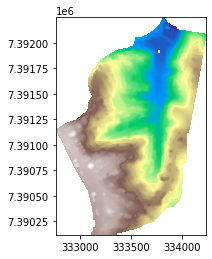

In [3]:
show(dataset, cmap='terrain')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from pysheds.grid import Grid
# import mplleaflet
%matplotlib inline

In [16]:
grid = Grid.from_raster('./resultados/MDT-Área de Análise - PUPSP-10m.tif', data_name='dem')

In [17]:
from matplotlib import pyplot as plt

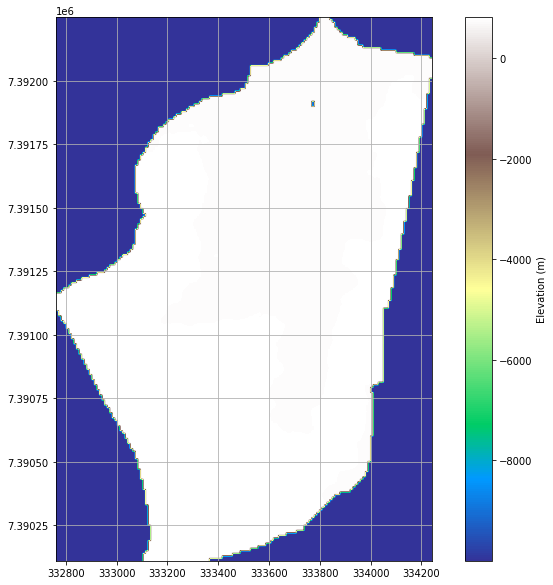

In [18]:
def plotFigure(data, label, cmap='terrain'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()
    

    
# plotFigure(grid.view('dem', nodata=np.nan), 'Elevation (m)')

In [19]:
# Detect depressions
depressions = grid.detect_depressions('dem')
grid.fill_depressions(data='dem', out_name='flooded_dem')

In [20]:
grid.nodata = np.nan
grid.dem.mask


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [21]:
# Detect flats
flats = grid.detect_flats('flooded_dem', nodata=np.nan)

In [22]:
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')
# plotFigure(grid.view('inflated_dem', nodata=np.nan), 'Elevation (m)')

In [23]:
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow direction based on corrected DEM
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

# Compute flow accumulation based on computed flow direction
grid.accumulation(data='dir', out_name='acc', dirmap=dirmap)

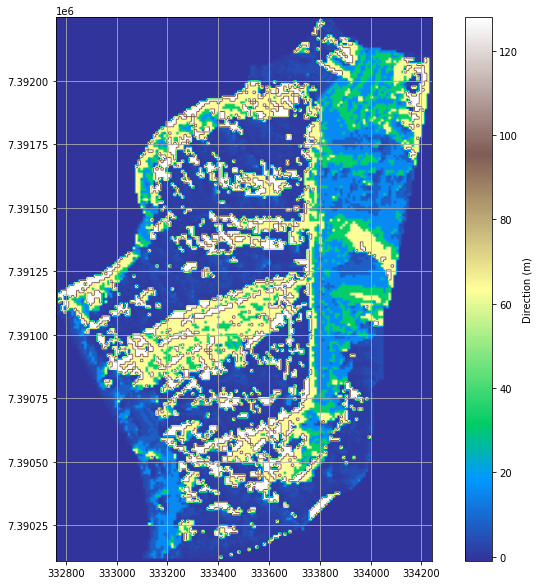

In [24]:
plotFigure(grid.view('dir', nodata=np.nan), 'Direction (m)')

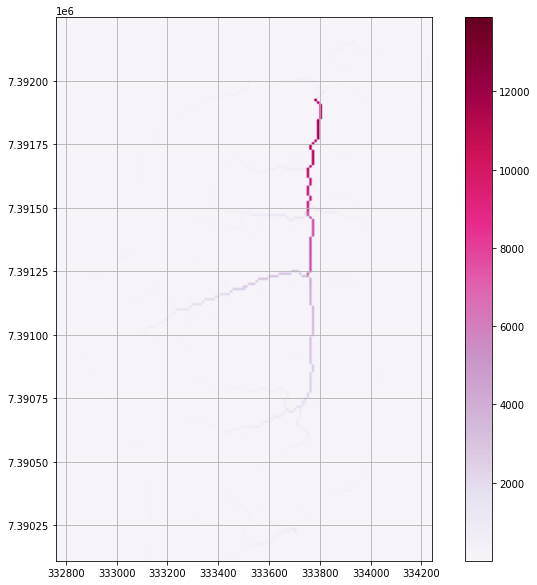

In [25]:
plotFigure(grid.view('acc', nodata=np.nan), '', cmap='PuRd')

Text(0, 0.5, 'Latitude')

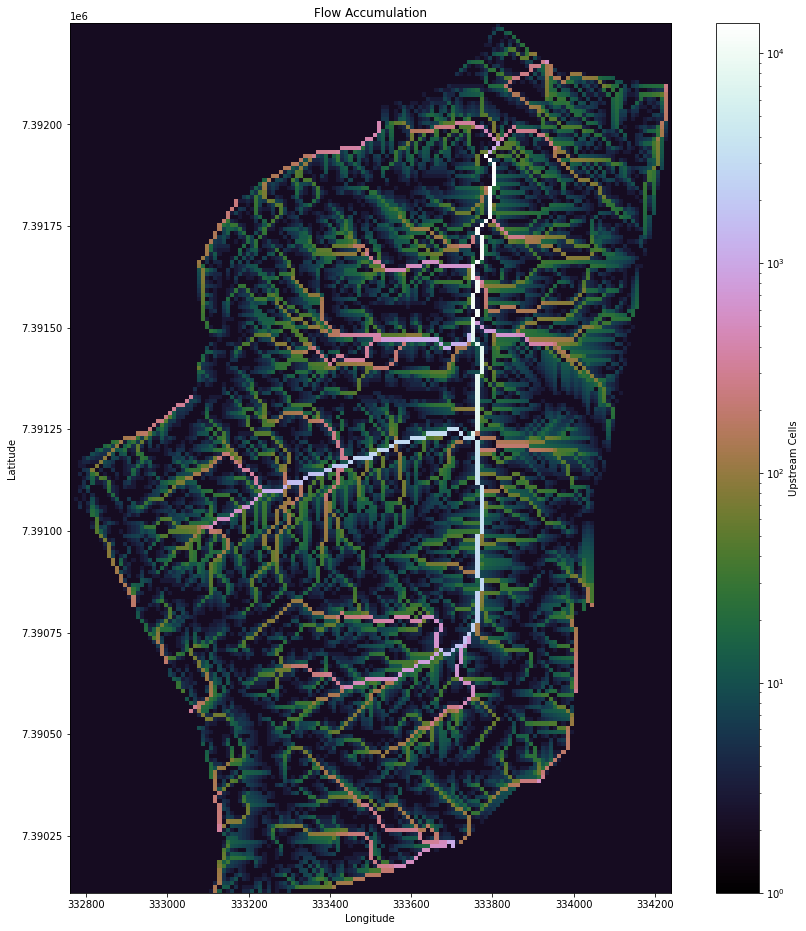

In [26]:
fig, ax = plt.subplots(figsize=(16,16))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
acc_img = np.where(grid.mask, grid.acc + 1, np.nan)
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [28]:
branches = grid.extract_river_network('dir', 'acc', threshold=50)

In [29]:
len(branches['features'])

209

In [37]:
branches.type = "FeatureCollection"

In [38]:
branches.name = "cusros_dagua-SIRGAS2000"

In [39]:
branches.crs = { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::31983" } }

In [40]:
def saveDict(dic,file):
    f = open(file,'w')
    f.write(str(dic))
    f.close()

saveDict(branches, './resultados/cusros_dagua.geojson')